In [36]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchinfo import summary
from torchview import draw_graph

In [37]:
# Hyper Parameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
EPOCHS = 1000
patience = 30
input_size = 2
hidden_size = 64
num_layers = 3
output_size = 10
dropout_prob = 0.25

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Function

In [39]:
def train_epoch(model, dataloader, loss_fn, optimizer, device) -> float:
    size = len(dataloader.dataset) # Total number of samples in the dataset
    num_batches = len(dataloader)  # Number of batches per epoch
    train_loss, train_correct = 0.0, 0.0
    model.train()  # Set model to training mode50
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)  # Forward propagation
        loss = loss_fn(output, y)  # Calculate loss
        train_loss += loss.item()  # Accumulate loss
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_correct += (output.argmax(1) == y).type(torch.float).sum().item() # Compute the number of correct predictions

    return train_loss/num_batches, 100*train_correct/size  # Return average loss

In [40]:
def valid_epoch(model, dataloader, loss_fn, device) -> float:
    size = len(dataloader.dataset) # Total number of samples in the dataset
    num_batches = len(dataloader)  # Number of batches per epoch
    valid_loss, valid_correct = 0.0, 0.0
    model.eval()  # Set model to evaluation mode
    with torch.inference_mode(mode=True):
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            output = model(x)  # Get model prediction
            loss = loss_fn(output, y)  # Calculate loss
            valid_loss += loss.item()  # Accumulate loss
            valid_correct += (output.argmax(1) == y).type(torch.float).sum().item() # Compute the number of correct predictions
    return valid_loss/num_batches, 100*valid_correct/size  # Return average loss

In [41]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, scheduler, epochs, device, patience):
    best_valid_loss = float('inf')
    current_patience = 0
    # Initializes a defaultdict to store the training and validation losses at each epoch
    result = defaultdict(list)
    # Moved the model to the specified device
    model.to(device)
    # Iterates through each epoch
    for epoch in tqdm(range(1, epochs + 1)):
        # Train the model and calculate the training loss
        train_loss, train_acc = train_epoch(
            model, train_loader, loss_fn, optimizer, device)
        # Calculate the validation loss
        valid_loss, valid_acc = valid_epoch(model, valid_loader, loss_fn, device)
        # Appended the training and validation losses to the result
        result['train_loss'].append(train_loss)
        result['train_accuracy'].append(train_acc)
        result['valid_loss'].append(valid_loss)
        result['valid_accuracy'].append(valid_acc)
        if epoch % 5 == 0:
            print(f"Epoch: {epoch} Train accuracy: {train_acc} Train loss: {train_loss} Valid accuracy: {valid_acc} Valid loss: {valid_loss}")
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                print(f"Early stopping triggered. No improvement in {patience} epochs.")
                print(f"Epoch: {epoch} Train accuracy: {train_acc} Train loss: {train_loss} Valid accuracy: {valid_acc} Valid loss: {valid_loss}")
                break
    return result  # Return the training and validation losses at each epoch


In [71]:
def plot(result, name):
    # Plot the Accuracy history

    # Get the number of epochs
    epochs = range(len(result['train_accuracy']))

    # Create a new figure for the plot
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)
    # Set the title of the plot
    plt.title('Training and Validation Accuracy')
    # Set the label for the x-axis
    plt.xlabel('Epochs')
    # Set the label for the y-axis
    plt.ylabel('Accuracy')
    # Plot the training loss over epochs
    plt.plot(epochs, result['train_accuracy'], label='train accuracy')
    # Plot the validation loss over epochs
    plt.plot(epochs, result['valid_accuracy'], label='valid accuracy')
    # Add a legend to the plot
    plt.legend()
    # plt.tight_layout()
    # Save the plot
    # plt.savefig('Training and Validation Accuracy.png')
    # Display the plot
    # plt.show()

    # Plot the Loss history

    # Create a new figure for the plot
    # plt.figure()
    plt.subplot(1,2,2)
    # Set the title of the plot
    plt.title('Training and Validation Loss')
    # Set the label for the x-axis
    plt.xlabel('Epochs')
    # Set the label for the y-axis
    plt.ylabel('Loss')
    # Plot the training loss over epochs
    plt.plot(epochs, result['train_loss'], label='train loss')
    # Plot the validation loss over epochs
    plt.plot(epochs, result['valid_loss'], label='valid loss')
    # Add a legend to the plot
    plt.legend()
    plt.tight_layout()
    # Save the plot
    # plt.savefig('Training and Validation Loss.png')
    plt.savefig(name)
    # Display the plot
    plt.show()

In [43]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
#         super(RNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn1 = nn.RNN(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.rnn2 = nn.RNN(hidden_size * 2, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_prob)
#         self.rnn3 = nn.RNN(hidden_size * 2, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout3 = nn.Dropout(dropout_prob)
#         self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
#         self.fc = nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.rnn1(x, h0)
#         out = self.dropout1(out)
#         out, _ = self.rnn2(out, h0)
#         out = self.dropout2(out)
#         out, _ = self.rnn3(out, h0)
#         out = self.dropout3(out)
#         out = out.permute(0, 2, 1)
#         out = self.batch_norm(out)
#         out = out.permute(0, 2, 1)
#         out = out[:, -1, :]
#         out = self.fc(out)
#         return out


In [44]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, bidirectional=True)
        for name, param in self.rnn.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight" in name:
                nn.init.orthogonal_(param)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [45]:
# class GRU(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
#         super(GRU, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru1 = nn.GRU(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.gru2 = nn.GRU(hidden_size * 2, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_prob)
#         self.gru3 = nn.GRU(hidden_size * 2, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout3 = nn.Dropout(dropout_prob)
#         self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
#         self.fc = nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.gru1(x, h0)
#         out = self.dropout1(out)
#         out, _ = self.gru2(out, h0)
#         out = self.dropout2(out)
#         out, _ = self.gru3(out, h0)
#         out = self.dropout3(out)
#         out = out.permute(0, 2, 1)
#         out = self.batch_norm(out)
#         out = out.permute(0, 2, 1)
#         out = out[:, -1, :]
#         out = self.fc(out)
#         return out


In [46]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, bidirectional=True)
        for name, param in self.gru.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight" in name:
                nn.init.orthogonal_(param)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [47]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_prob)
#         self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, bidirectional=True, batch_first=True)
#         self.dropout3 = nn.Dropout(dropout_prob)
#         self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
#         self.fc = nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm1(x, (h0, c0))
#         out = self.dropout1(out)
#         out, _ = self.lstm2(out, (h0, c0))
#         out = self.dropout2(out)
#         out, _ = self.lstm3(out, (h0, c0))
#         out = self.dropout3(out)
#         out = out.permute(0, 2, 1)
#         out = self.batch_norm(out)
#         out = out.permute(0, 2, 1)
#         out = out[:, -1, :]
#         out = self.fc(out)
#         return out


In [48]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, bidirectional=True)
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight" in name:
                nn.init.orthogonal_(param)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load Data

In [49]:
x = pd.read_csv('data/triain_in.csv').values[:, 1:]
y = pd.read_csv('data/train_out.csv').values[:, 1:]

In [50]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).long()
x = x.view(-1, 8, 2)
y = y.squeeze()
train_data = torch.utils.data.TensorDataset(x, y) 

In [51]:
train_size = int(0.8 * len(x))
val_size = len(x) - train_size

# Determine the sizes of the training and validation sets (0.8 for training, 0.2 for validation)
generator = torch.Generator().manual_seed(7)
train_dataset, val_dataset = random_split(train_data, [train_size, val_size], generator=generator) # Use the random_split to split the dataset

In [52]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### RNN

In [53]:
model_RNN = RNN(input_size, hidden_size, num_layers, output_size, dropout_prob)
loss_fn = nn.CrossEntropyLoss() # Define the loss function
optimizer = torch.optim.Adam(model_RNN.parameters(), lr=LEARNING_RATE) # Define the optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr = 1e-12, verbose=True)

In [54]:
# Perform the training and validation
result_RNN = train(model_RNN, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS, device, patience)

  0%|          | 5/1000 [00:02<08:44,  1.90it/s]

Epoch: 5 Train accuracy: 88.84070058381985 Train loss: 0.37225813006467007 Valid accuracy: 91.52768512341561 Valid loss: 0.25203749537467957


  1%|          | 10/1000 [00:05<08:30,  1.94it/s]

Epoch: 10 Train accuracy: 94.27856547122602 Train loss: 0.18494077271563894 Valid accuracy: 95.59706470980653 Valid loss: 0.13914989267892025


  2%|▏         | 15/1000 [00:07<08:21,  1.96it/s]

Epoch: 15 Train accuracy: 95.87989991659717 Train loss: 0.14455821800065485 Valid accuracy: 96.46430953969313 Valid loss: 0.09938424638413051


  2%|▏         | 20/1000 [00:10<08:24,  1.94it/s]

Epoch: 20 Train accuracy: 96.78065054211844 Train loss: 0.11055405553370873 Valid accuracy: 97.59839893262175 Valid loss: 0.07581102140644129


  2%|▎         | 25/1000 [00:12<08:14,  1.97it/s]

Epoch: 25 Train accuracy: 97.31442869057548 Train loss: 0.0907060070374505 Valid accuracy: 98.1320880587058 Valid loss: 0.05592865579107657


  3%|▎         | 30/1000 [00:15<08:07,  1.99it/s]

Epoch: 30 Train accuracy: 98.08173477898248 Train loss: 0.06836247420993614 Valid accuracy: 98.73248832555036 Valid loss: 0.046604436594358783


  4%|▎         | 35/1000 [00:17<08:06,  1.99it/s]

Epoch: 35 Train accuracy: 98.63219349457881 Train loss: 0.05157992495298187 Valid accuracy: 99.19946631087392 Valid loss: 0.03563709049039778


  4%|▍         | 40/1000 [00:20<08:05,  1.98it/s]

Epoch: 40 Train accuracy: 98.99916597164304 Train loss: 0.0397068167091694 Valid accuracy: 99.13275517011341 Valid loss: 0.034523117648279096


  4%|▍         | 44/1000 [00:22<08:04,  1.97it/s]

Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.


  4%|▍         | 45/1000 [00:23<08:03,  1.98it/s]

Epoch: 45 Train accuracy: 98.99916597164304 Train loss: 0.03518097032173636 Valid accuracy: 99.39959973315544 Valid loss: 0.027267330966424197


  5%|▌         | 50/1000 [00:25<08:20,  1.90it/s]

Epoch: 50 Train accuracy: 99.28273561301084 Train loss: 0.029964877558782934 Valid accuracy: 99.26617745163442 Valid loss: 0.03319333627463338


  6%|▌         | 55/1000 [00:28<08:21,  1.89it/s]

Epoch: 55 Train accuracy: 99.21601334445371 Train loss: 0.02918968249256029 Valid accuracy: 99.19946631087392 Valid loss: 0.030957852984392183


  6%|▌         | 58/1000 [00:29<08:21,  1.88it/s]

Epoch 00058: reducing learning rate of group 0 to 5.0000e-05.


  6%|▌         | 60/1000 [00:30<08:22,  1.87it/s]

Epoch: 60 Train accuracy: 99.36613844870726 Train loss: 0.025525634647025033 Valid accuracy: 99.33288859239492 Valid loss: 0.03012697845189634


  6%|▋         | 64/1000 [00:33<08:10,  1.91it/s]

Epoch 00064: reducing learning rate of group 0 to 2.5000e-05.


  6%|▋         | 65/1000 [00:33<08:06,  1.92it/s]

Epoch: 65 Train accuracy: 99.46622185154295 Train loss: 0.0227575841442771 Valid accuracy: 99.26617745163442 Valid loss: 0.03235219991450109


  7%|▋         | 70/1000 [00:36<07:58,  1.94it/s]

Epoch: 70 Train accuracy: 99.39949958298583 Train loss: 0.021415472129716517 Valid accuracy: 99.33288859239492 Valid loss: 0.028917816839740672
Epoch 00070: reducing learning rate of group 0 to 1.2500e-05.


  8%|▊         | 75/1000 [00:38<07:58,  1.93it/s]

Epoch: 75 Train accuracy: 99.44954128440367 Train loss: 0.021051121115847986 Valid accuracy: 99.33288859239492 Valid loss: 0.030616242764889202


  8%|▊         | 76/1000 [00:39<07:56,  1.94it/s]

Epoch 00076: reducing learning rate of group 0 to 6.2500e-06.


  8%|▊         | 80/1000 [00:41<07:50,  1.96it/s]

Epoch: 80 Train accuracy: 99.53294412010008 Train loss: 0.018630237290710012 Valid accuracy: 99.33288859239492 Valid loss: 0.030446139173557426


  8%|▊         | 81/1000 [00:42<07:59,  1.91it/s]

Epoch 00082: reducing learning rate of group 0 to 3.1250e-06.
Early stopping triggered. No improvement in 30 epochs.
Epoch: 82 Train accuracy: 99.49958298582152 Train loss: 0.019626226495057245 Valid accuracy: 99.26617745163442 Valid loss: 0.030356594374059066


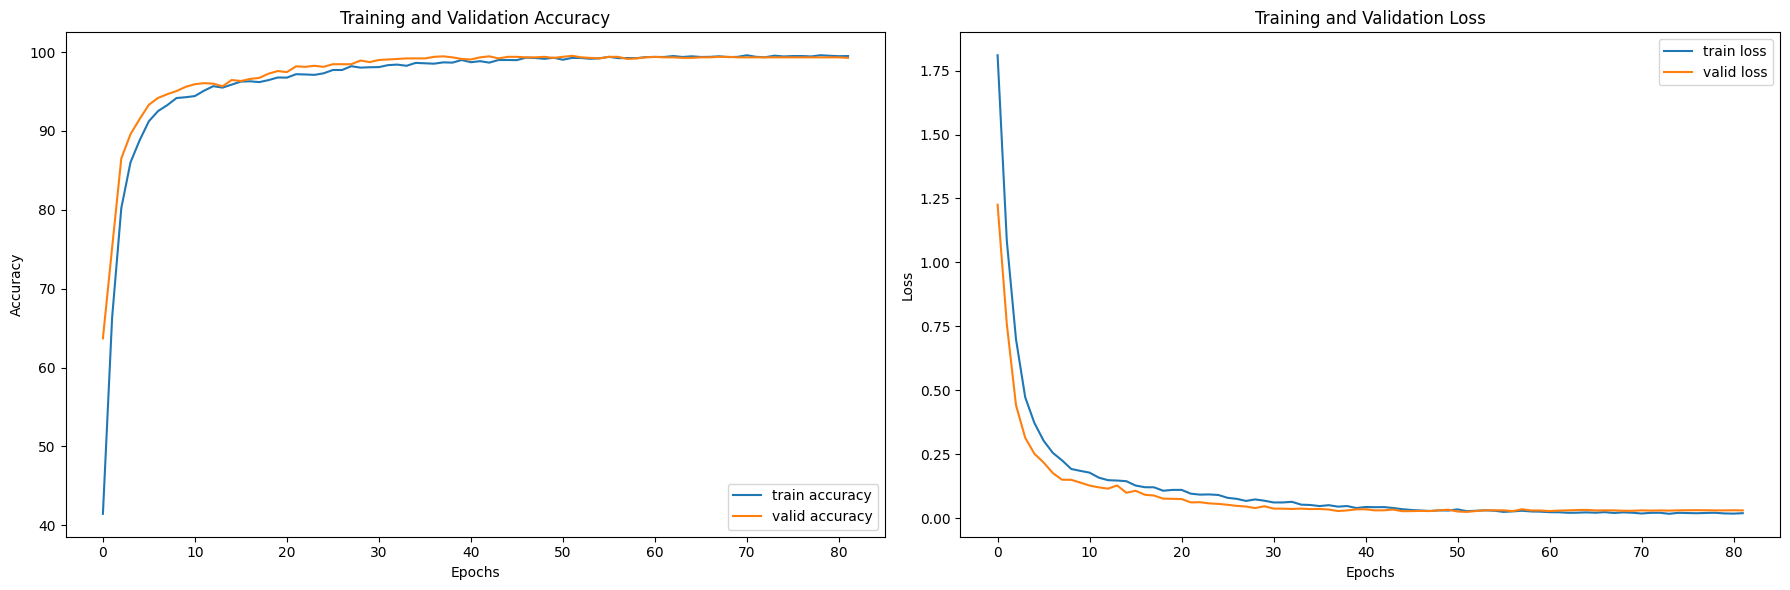

In [72]:
plot(result_RNN, 'img/RNN Training and Validation History.png')

### GRU

In [56]:
model_GRU = GRU(input_size, hidden_size, num_layers, output_size, dropout_prob)
loss_fn = nn.CrossEntropyLoss() # Define the loss function
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=LEARNING_RATE) # Define the optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr = 1e-12, verbose=True)

In [57]:
# Perform the training and validation
result_GRU = train(model_GRU, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS, device, patience)

  0%|          | 5/1000 [00:02<08:42,  1.90it/s]

Epoch: 5 Train accuracy: 91.2927439532944 Train loss: 0.26824616668547724 Valid accuracy: 93.3955970647098 Valid loss: 0.202295970330213


  1%|          | 10/1000 [00:05<08:35,  1.92it/s]

Epoch: 10 Train accuracy: 95.8465387823186 Train loss: 0.1425207063476456 Valid accuracy: 96.39759839893262 Valid loss: 0.09506988864233519


  2%|▏         | 15/1000 [00:07<08:35,  1.91it/s]

Epoch: 15 Train accuracy: 97.28106755629692 Train loss: 0.09207638110371029 Valid accuracy: 96.99799866577719 Valid loss: 0.0871835452345933


  2%|▏         | 20/1000 [00:10<08:25,  1.94it/s]

Epoch: 20 Train accuracy: 97.88156797331109 Train loss: 0.06776732060206221 Valid accuracy: 98.1320880587058 Valid loss: 0.05880599317854231


  2%|▎         | 25/1000 [00:13<08:22,  1.94it/s]

Epoch: 25 Train accuracy: 98.96580483736447 Train loss: 0.038869068442665515 Valid accuracy: 98.33222148098733 Valid loss: 0.04657784874174506


  3%|▎         | 30/1000 [00:15<08:25,  1.92it/s]

Epoch: 30 Train accuracy: 98.96580483736447 Train loss: 0.033291315440053836 Valid accuracy: 99.19946631087392 Valid loss: 0.02572170518923234


  4%|▎         | 35/1000 [00:18<08:14,  1.95it/s]

Epoch: 35 Train accuracy: 99.08256880733946 Train loss: 0.031017897473499575 Valid accuracy: 98.93262174783189 Valid loss: 0.03691408537796381


  4%|▎         | 37/1000 [00:19<08:12,  1.96it/s]

Epoch 00037: reducing learning rate of group 0 to 2.0000e-05.


  4%|▍         | 40/1000 [00:20<08:15,  1.94it/s]

Epoch: 40 Train accuracy: 99.54962468723937 Train loss: 0.01679737041914895 Valid accuracy: 99.39959973315544 Valid loss: 0.021635687695766622


  4%|▍         | 45/1000 [00:23<08:16,  1.92it/s]

Epoch: 45 Train accuracy: 99.6163469557965 Train loss: 0.01703105657423371 Valid accuracy: 99.46631087391594 Valid loss: 0.02110206722925873


  5%|▌         | 50/1000 [00:26<08:04,  1.96it/s]

Epoch: 50 Train accuracy: 99.6997497914929 Train loss: 0.012962256680227855 Valid accuracy: 99.39959973315544 Valid loss: 0.022787859902699836


  5%|▌         | 54/1000 [00:28<08:03,  1.96it/s]

Epoch 00054: reducing learning rate of group 0 to 2.0000e-06.


  6%|▌         | 55/1000 [00:28<08:06,  1.94it/s]

Epoch: 55 Train accuracy: 99.64970809007507 Train loss: 0.013068018730994849 Valid accuracy: 99.39959973315544 Valid loss: 0.021681616357725825


  6%|▌         | 60/1000 [00:31<08:07,  1.93it/s]

Epoch: 60 Train accuracy: 99.63302752293578 Train loss: 0.015175495725533766 Valid accuracy: 99.39959973315544 Valid loss: 0.02115828124806285
Epoch 00060: reducing learning rate of group 0 to 2.0000e-07.


  6%|▋         | 65/1000 [00:33<08:03,  1.93it/s]

Epoch: 65 Train accuracy: 99.78315262718932 Train loss: 0.012870668766442984 Valid accuracy: 99.39959973315544 Valid loss: 0.02107974576597855


  7%|▋         | 66/1000 [00:34<08:07,  1.92it/s]

Epoch 00066: reducing learning rate of group 0 to 2.0000e-08.


  7%|▋         | 70/1000 [00:36<08:04,  1.92it/s]

Epoch: 70 Train accuracy: 99.66638865721434 Train loss: 0.013606406474285362 Valid accuracy: 99.39959973315544 Valid loss: 0.021061976643977687


  7%|▋         | 72/1000 [00:37<08:01,  1.93it/s]

Epoch 00072: reducing learning rate of group 0 to 2.0000e-09.


  8%|▊         | 75/1000 [00:38<08:02,  1.92it/s]

Epoch: 75 Train accuracy: 99.7164303586322 Train loss: 0.015200717166930616 Valid accuracy: 99.39959973315544 Valid loss: 0.02106251858145078


  8%|▊         | 77/1000 [00:40<08:06,  1.90it/s]

Early stopping triggered. No improvement in 30 epochs.
Epoch: 78 Train accuracy: 99.64970809007507 Train loss: 0.01336784724627889 Valid accuracy: 99.39959973315544 Valid loss: 0.02106421466816484


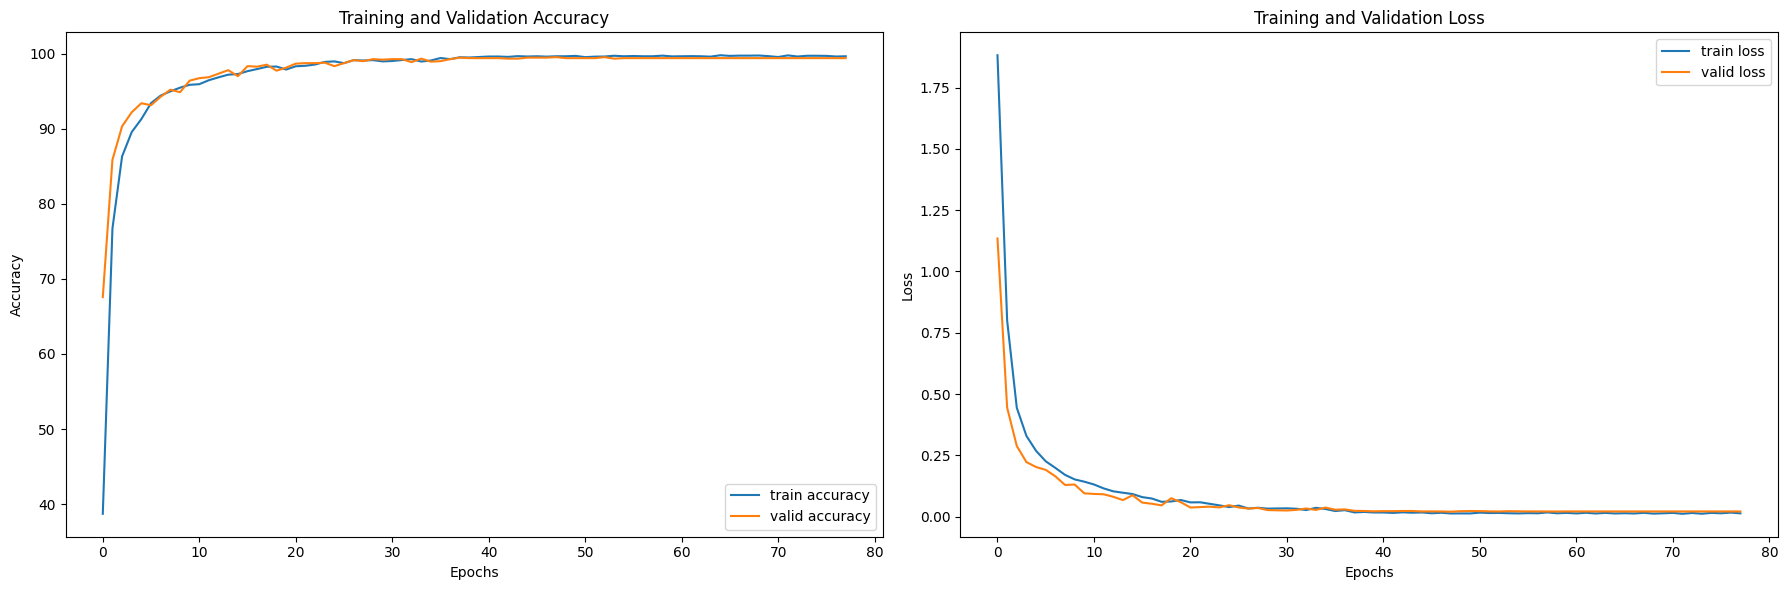

In [73]:
plot(result_GRU, 'img/GRU Training and Validation History.png')

### LSTM

In [59]:
model_LSTM = LSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
loss_fn = nn.CrossEntropyLoss() # Define the loss function
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=LEARNING_RATE) # Define the optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr = 1e-12, verbose=True)

In [60]:
# Perform the training and validation
result_LSTM = train(model_LSTM, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS, device, patience)

  0%|          | 5/1000 [00:02<08:51,  1.87it/s]

Epoch: 5 Train accuracy: 91.75979983319432 Train loss: 0.28281026420758126 Valid accuracy: 94.46297531687792 Valid loss: 0.17245328838520863


  1%|          | 10/1000 [00:05<08:46,  1.88it/s]

Epoch: 10 Train accuracy: 96.18015012510425 Train loss: 0.1325154035907001 Valid accuracy: 97.66511007338225 Valid loss: 0.07678898921276027


  2%|▏         | 15/1000 [00:08<08:45,  1.87it/s]

Epoch: 15 Train accuracy: 97.54795663052543 Train loss: 0.08687710703568573 Valid accuracy: 97.06470980653769 Valid loss: 0.0830505991632


  2%|▏         | 20/1000 [00:10<08:34,  1.90it/s]

Epoch: 20 Train accuracy: 98.3653044203503 Train loss: 0.06330109129045555 Valid accuracy: 98.33222148098733 Valid loss: 0.054247761947756754


  2%|▎         | 25/1000 [00:13<08:29,  1.92it/s]

Epoch: 25 Train accuracy: 98.34862385321101 Train loss: 0.05890837702850633 Valid accuracy: 98.39893262174783 Valid loss: 0.047565484231219014


  3%|▎         | 30/1000 [00:15<08:30,  1.90it/s]

Epoch: 30 Train accuracy: 98.68223519599667 Train loss: 0.047464586342338154 Valid accuracy: 98.79919946631087 Valid loss: 0.043524502885547725


  3%|▎         | 32/1000 [00:16<08:29,  1.90it/s]

Epoch 00032: reducing learning rate of group 0 to 2.0000e-05.


  4%|▎         | 35/1000 [00:18<08:20,  1.93it/s]

Epoch: 35 Train accuracy: 99.38281901584654 Train loss: 0.02504202252826059 Valid accuracy: 99.0660440293529 Valid loss: 0.0281243478864471


  4%|▍         | 40/1000 [00:21<08:58,  1.78it/s]

Epoch: 40 Train accuracy: 99.39949958298583 Train loss: 0.023799950095324558 Valid accuracy: 99.33288859239492 Valid loss: 0.02709096091294146


  4%|▍         | 45/1000 [00:24<09:03,  1.76it/s]

Epoch: 45 Train accuracy: 99.36613844870726 Train loss: 0.023382195559493762 Valid accuracy: 99.26617745163442 Valid loss: 0.025614315918844905


  5%|▌         | 50/1000 [00:26<08:25,  1.88it/s]

Epoch: 50 Train accuracy: 99.43286071726439 Train loss: 0.022396235863004436 Valid accuracy: 99.53302201467645 Valid loss: 0.02507930334615323


  6%|▌         | 55/1000 [00:29<08:21,  1.88it/s]

Epoch: 55 Train accuracy: 99.39949958298583 Train loss: 0.02027421634572439 Valid accuracy: 99.19946631087392 Valid loss: 0.026188512488783514


  6%|▌         | 58/1000 [00:30<08:10,  1.92it/s]

Epoch 00058: reducing learning rate of group 0 to 2.0000e-06.


  6%|▌         | 60/1000 [00:32<08:15,  1.90it/s]

Epoch: 60 Train accuracy: 99.4161801501251 Train loss: 0.01919559522301573 Valid accuracy: 99.33288859239492 Valid loss: 0.025820698099275258


  6%|▋         | 64/1000 [00:34<08:16,  1.88it/s]

Epoch 00064: reducing learning rate of group 0 to 2.0000e-07.


  6%|▋         | 65/1000 [00:34<08:12,  1.90it/s]

Epoch: 65 Train accuracy: 99.38281901584654 Train loss: 0.020220740323024306 Valid accuracy: 99.33288859239492 Valid loss: 0.02592034312027031


  7%|▋         | 70/1000 [00:37<08:26,  1.84it/s]

Epoch: 70 Train accuracy: 99.44954128440367 Train loss: 0.020740260985590755 Valid accuracy: 99.33288859239492 Valid loss: 0.02581844951070726
Epoch 00070: reducing learning rate of group 0 to 2.0000e-08.


  8%|▊         | 75/1000 [00:40<08:31,  1.81it/s]

Epoch: 75 Train accuracy: 99.54962468723937 Train loss: 0.02011580208528222 Valid accuracy: 99.33288859239492 Valid loss: 0.025779283788808165


  8%|▊         | 76/1000 [00:40<08:42,  1.77it/s]

Epoch 00076: reducing learning rate of group 0 to 2.0000e-09.


  8%|▊         | 80/1000 [00:42<08:22,  1.83it/s]

Epoch: 80 Train accuracy: 99.49958298582152 Train loss: 0.020253431143615632 Valid accuracy: 99.33288859239492 Valid loss: 0.02578011286095716


  8%|▊         | 81/1000 [00:44<08:19,  1.84it/s]

Early stopping triggered. No improvement in 30 epochs.
Epoch: 82 Train accuracy: 99.56630525437865 Train loss: 0.018734489699783537 Valid accuracy: 99.33288859239492 Valid loss: 0.02578006487121766


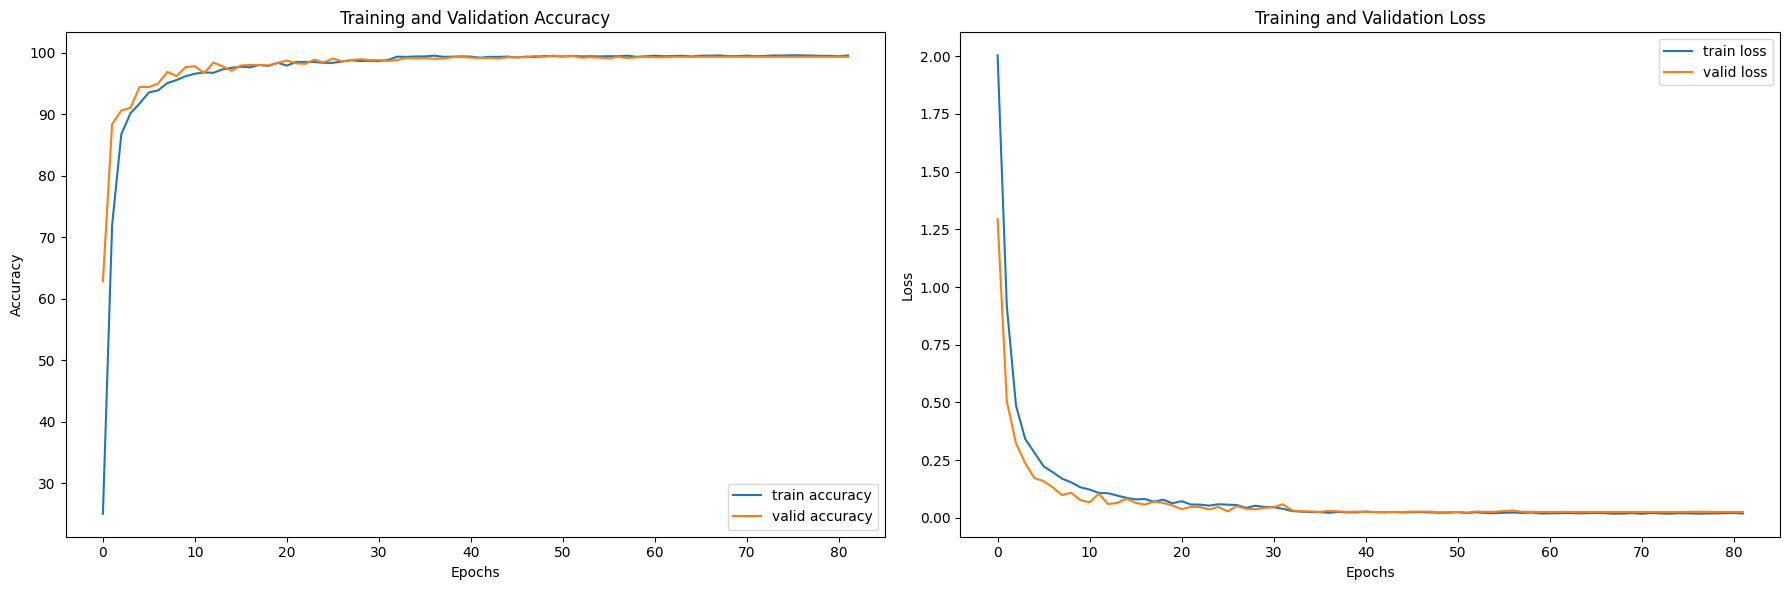

In [74]:
plot(result_LSTM, 'img/LSTM Training and Validation History.png')

### Test

In [62]:
x_test = pd.read_csv('data/test_in.csv').values[:, 1:] 
x_test = torch.from_numpy(x_test).float()
x_test = x_test.view(-1, 8, 2) 

model_RNN.eval()
with torch.no_grad():
    x_test = x_test.to(device)
    output = model_RNN(x_test)
    _, predicted = torch.max(output.data, 1)

predicted = predicted.cpu().numpy()
submission = pd.DataFrame({'Label': predicted})
submission.index += 1  # 調整索引從 1 開始
submission.to_csv('submission/submission_RNN.csv', index_label='Serial No.')

In [63]:
x_test = pd.read_csv('data/test_in.csv').values[:, 1:] 
x_test = torch.from_numpy(x_test).float()
x_test = x_test.view(-1, 8, 2) 

model_GRU.eval()
with torch.no_grad():
    x_test = x_test.to(device)
    output = model_GRU(x_test)
    _, predicted = torch.max(output.data, 1)

predicted = predicted.cpu().numpy()
submission = pd.DataFrame({'Label': predicted})
submission.index += 1  # 調整索引從 1 開始
submission.to_csv('submission/submission_GRU.csv', index_label='Serial No.')

In [64]:
x_test = pd.read_csv('data/test_in.csv').values[:, 1:] 
x_test = torch.from_numpy(x_test).float()
x_test = x_test.view(-1, 8, 2) 

model_LSTM.eval()
with torch.no_grad():
    x_test = x_test.to(device)
    output = model_LSTM(x_test)
    _, predicted = torch.max(output.data, 1)

predicted = predicted.cpu().numpy()
submission = pd.DataFrame({'Label': predicted})
submission.index += 1  # 調整索引從 1 開始
submission.to_csv('submission/submission_LSTM.csv', index_label='Serial No.')

In [65]:
# Print the model summary
summary(model_RNN, input_size=(1, 8, 2))

c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 10]                   --
├─RNN: 1-1                               [1, 8, 128]               58,368
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 64]                   8,256
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 10]                   650
Total params: 67,274
Trainable params: 67,274
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.27
Estimated Total Size (MB): 0.28


(dot.exe:12384): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:4948): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


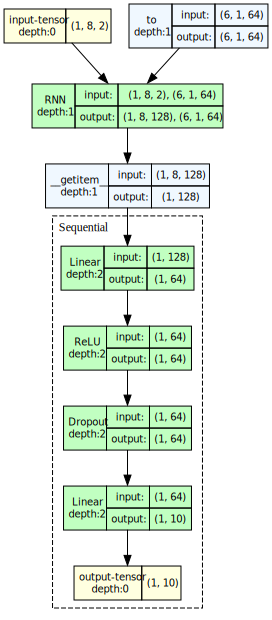

In [66]:
graph = draw_graph(model_RNN, input_size=(1, 8, 2), expand_nested=True, save_graph=True, filename='model/RNN_Model')
graph.visual_graph

In [67]:
# Print the model summary
summary(model_GRU, input_size=(1, 8, 2))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [1, 10]                   --
├─GRU: 1-1                               [1, 8, 128]               175,104
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 64]                   8,256
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 10]                   650
Total params: 184,010
Trainable params: 184,010
Non-trainable params: 0
Total mult-adds (M): 1.41
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.74
Estimated Total Size (MB): 0.74


(dot.exe:12148): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:11496): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


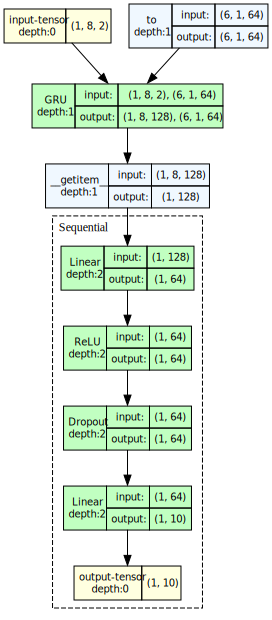

In [68]:
graph = draw_graph(model_GRU, input_size=(1, 8, 2), expand_nested=True, save_graph=True, filename='model/GRU_Model')
graph.visual_graph

In [69]:
# Print the model summary
summary(model_LSTM, input_size=(1, 8, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 10]                   --
├─LSTM: 1-1                              [1, 8, 128]               233,472
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 64]                   8,256
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 10]                   650
Total params: 242,378
Trainable params: 242,378
Non-trainable params: 0
Total mult-adds (M): 1.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.97
Estimated Total Size (MB): 0.98


(dot.exe:7672): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:16696): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


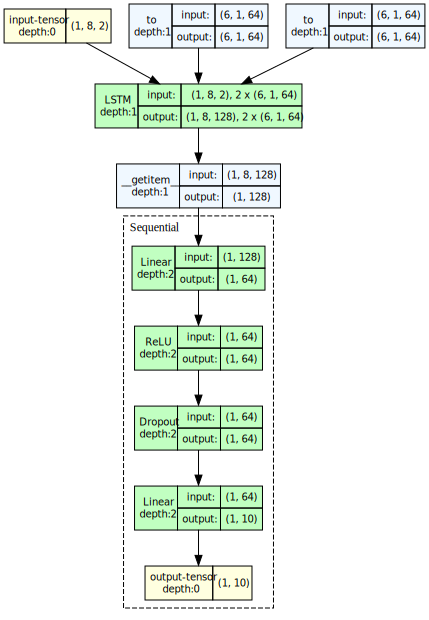

In [70]:
graph = draw_graph(model_LSTM, input_size=(1, 8, 2), expand_nested=True, save_graph=True, filename='model/LSTM_Model')
graph.visual_graph